# CSC 580
# Assignment 5
# Hithesh Shanmugam

# 2023 HW#5 Atari Breakout using DQN -- New Starter Code (as of 2/11)

# 1. CoLab Setup

In [1]:
## Code piece to mount my Google Drive
from google.colab import drive 
drive.mount("/content/drive") # my Google Drive root directory will be mapped here

Mounted at /content/drive


In [2]:
# Change the working directory to your own work directory (where the code file is).
import os
thisdir = '/content/drive/My Drive'
os.chdir(thisdir)

# Ensure the files are there (in the folder)
!pwd

/content/drive/My Drive


# 2. Install libraries related to graphics and Gymnasium

In [3]:
!apt-get update
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:9 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2,069 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:14 http://archive.ubuntu.com/ubun

In [4]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import pyvirtualdisplay

In [ ]:
# % to ensure the libraries are installed in the current environment
%pip install gymnasium[atari]
%pip install gymnasium[accept-rom-license]
%pip install ale-py     # critical for rendering Atari screens

In [6]:
# First import the ALE
from ale_py import ALEInterface

ale = ALEInterface()

# 3. Preliminary step to inspect states and rendering

action_space=4, observation_space=(210, 160, 3)


/usr/local/lib/python3.8/dist-packages/gymnasium/utils/passive_env_checker.py:357: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


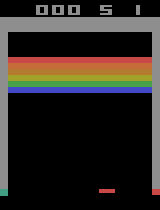

In [7]:
import gymnasium as gym

env = gym.make("ALE/Breakout-v5", render_mode='rgb_array', full_action_space=False)

# Various information about the environment
print ("action_space={}, observation_space={}".format(env.action_space.n, env.observation_space.shape))

observation = env.reset() # initial state/observation returned
#print (observation[0][180])

#env.render()  # returns an array of (210, 160, 3), each in the range [0-255]
Image.fromarray(env.render())

# 4. Install tensorflow 

In [ ]:
%pip install tensorflow

import tensorflow as tf
from tensorflow import keras
tf.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'2.11.0'

In [8]:
import numpy as np

def crop_Atari_frame(frame):
    return frame[30:-12,5:-4]  # crop out irrelevant parts in the frame/image

def resize_and_gray(frame, newsize, gray = False):
    """ converts the frame/image array, possibly reduce to the gray scale,
        then resizes to the new size. 
    """
    frame = crop_Atari_frame(frame)       # first crop the frame/array
    im = Image.fromarray(np.uint8(frame)) # convert the array to a PIL image
    if gray:
      im = ImageOps.grayscale(im)  # convert to grayscale using PIL ImageOps

    im = im.resize(newsize)  # resize the PIL image to the desired size
    return np.array(im, dtype = np.uint8) # convert back to an np array

Image shape: (84, 84, 3)


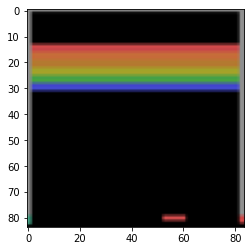

In [9]:
import gymnasium as gym
import matplotlib.pyplot as plt

env = gym.make("ALE/Breakout-v5", render_mode='rgb_array', full_action_space=False)
state = env.reset()

newsize = (84, 84)  # reduced, new size!!

## convert the frame to a smaller color image
first_frame = resize_and_gray(state[0], newsize)  # new size, but still in color
print ("Image shape: {}".format(first_frame.shape))
plt.imshow(first_frame)

Image shape: (84, 84)


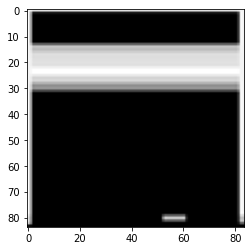

In [10]:
## convert the frame to a smaller grayscale image
first_frame = resize_and_gray(state[0], newsize, True) # new size, in grayscale
print ("Image shape: {}".format(first_frame.shape))
plt.imshow(first_frame,cmap='gray')

# 5. Define QNetwork and Memory

In [14]:
from tensorflow.keras import layers
from collections import deque
from tensorflow import keras
class QNetwork:
    def __init__(self, input_shape=(84, 84, 3), action_size=4, hidden_size=126,
                 learning_rate = 0.001):
        # First fix up input_shape in case it is a 2D grayscale image
        if len(input_shape) < 3:
            input_shape = (input_shape[0], input_shape[1], 1)
        print ('input_shape = {}'.format(input_shape))

        # Model in the original Deepmind DQN paper (but reduced to assume one frame)
        self.model = keras.Sequential()
        self.model.add(layers.Conv2D(32, 8, strides=4, activation="relu",
                                    input_shape=input_shape))
        self.model.add(layers.Conv2D(64, 4, strides=2, activation="relu"))
        self.model.add(layers.Conv2D(64, 3, strides=1, activation="relu"))
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(hidden_size, activation="relu"))
        self.model.add(layers.Dense(action_size, activation="linear"))

        # other compile parameters
        self.optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
        self.model.compile(loss=keras.losses.Huber(), optimizer=self.optimizer)

    def get_weights(self):
        return self.model.get_weights()

    def set_weights(self, weights):
        self.model.set_weights(weights)


class Memory():
    """ Replay memory """
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)),
                               size=batch_size,
                               replace=False)
        return [self.buffer[ii] for ii in idx]

    def __len__(self):
        return len(self.buffer)

# 6. Fill the Memory with episode steps

In [12]:
###################################
## Populate the experience memory
###################################

# Newly create the Atari Breakout game environment
env = gym.make("ALE/Breakout-v5", render_mode='rgb_array', full_action_space=False)
newsize = (84, 84)
grayscale = False

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 16                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

INIT_MEMORY = 100

memory = Memory(max_size=memory_size)

#----------------
print ("* Populate the experience memory with {} steps *".format(INIT_MEMORY))

# Initialize the simulation
observation = env.reset()
state = resize_and_gray(observation[0], newsize)

# Make a bunch of random actions and store the experiences
for _ in range(INIT_MEMORY):
    # render commented since it doesn't work well on CoLab without video
    #env.render()

    # Make a/one random action
    action = env.action_space.sample()
    # take the action
    next_state, reward, done, info, _ = env.step(action)

    # resize the image of next_state
    next_state = resize_and_gray(next_state, newsize, grayscale)

    # Add experience (a four-tuple) to memory.
    # (**) Keras predict processes a batch, so when you're using a single  
    #  image, you need to add it to a list (by expanding the row dimension):
    memory.add((np.expand_dims(state, axis=0), action, reward, 
                np.expand_dims(next_state, axis=0), done))

    if done:
        # Start a new episode
        env.reset()
        # Take one random step to get started
        state, reward, done, info = env.step(env.action_space.sample())
        state = resize_and_gray(state, newsize, grayscale)
    else:
        # go to the next state
        state = next_state

print ("Done!")     
  

* Populate the experience memory with 100 steps *
Done!


# 7. Create DQN networks ('model_pred', which utilizes 'model_target') as Agent 

In [15]:
# The first model makes the predictions for Q-values which are used to
# make a action.
image_shape = (memory.buffer[0][0][0]).shape
num_actions = env.action_space.n

model_pred = QNetwork(input_shape = image_shape, action_size = num_actions, 
                      hidden_size=126)

# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 1000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = QNetwork(input_shape = image_shape, action_size = num_actions, 
                        hidden_size=126)

input_shape = (84, 84, 3)
input_shape = (84, 84, 3)


(1, 84, 84, 3)


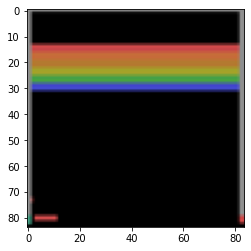

In [16]:
frame = memory.sample(1)[0]
frame_state = frame[0]      # 1st element in the four tuple
print(frame_state.shape)    # still in a batch of one

plt.imshow(frame_state[0])  # show only the image

In [17]:
# convert values of the image into range [0, 1]
frame_state = frame_state / 255.0

# Now make predictions (for all actions)
predictions = model_pred.model.predict(frame_state)
print (predictions[0])  # [0] because there is only one result in predictions

1/1 [==============================] - 7s 7s/step
[-0.05206496 -0.03269528 -0.08211996 -0.00792162]


# 8. Your Training Code goes here!!!

In [33]:
import random
from keras.optimizers import Adam

class DQNAgent():
    def __init__(self, env, state_shape, action_size, batch_size=32, gamma=0.99, learning_rate=0.001, epsilon=0.5, epsilon_min=0.01, epsilon_decay=0.995):
        # Initialize the DQNAgent with the environment, state shape, action size, batch size, discount factor (gamma), learning rate, exploration rate (epsilon), minimum exploration rate, and exploration rate decay
        self.env = env
        self.state_shape = state_shape
        self.action_size = action_size

        # Create a replay buffer to store experiences
        self.replay_buffer = Memory(max_size=memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Initialize the neural networks for predicting Q values and updating target network weights
        self.prediction_model = QNetwork(input_shape = image_shape, action_size = num_actions, hidden_size=126)
        self.target_model = QNetwork(input_shape = image_shape, action_size = num_actions, hidden_size=126)

        # Set the weights of the target model to the weights of the prediction model
        self.target_model.set_weights(self.prediction_model.get_weights())

        # Compile the prediction model with the mean squared error loss and the Adam optimizer
        self.prediction_model.model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

    def act(self, state):
        # Choose an action using epsilon-greedy exploration
        if np.random.rand() < self.epsilon:
          # Select a random action
          action = self.env.action_space.sample()
        else:
          # Use the prediction model to select the action with the highest predicted Q value
          action = np.argmax(self.prediction_model.model.predict(np.array([state])))
        return action
    
    def remember(self, state, action, reward, next_state, done):
        # Add the experience to the replay buffer
        self.replay_buffer.add((state, action, reward, next_state, done))
        
    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        # Sample a batch of experiences from the replay buffer
        experiences = self.replay_buffer.sample(self.batch_size)

        # Separate the states, actions, rewards, next states, and dones from the experiences
        states = np.array([experience[0] for experience in experiences])
        
        actions = np.array([experience[1] for experience in experiences])
        rewards = np.array([experience[2] for experience in experiences])
        next_states = np.array([experience[3] for experience in experiences])
        dones = np.array([experience[4] for experience in experiences])

        # Calculate the target Q values for the batch using the target model
        q_values_next = self.target_model.model.predict(next_states)
        targets = rewards + (self.gamma * np.max(q_values_next, axis=1)) * (1 - dones)

        # Update the Q values for the batch in the prediction model
        q_values = self.prediction_model.model.predict(states)
        q_values[np.arange(len(actions)), actions] = targets

        # Train the prediction model on the batch of experiences
        self.prediction_model.model.fit(states, q_values, epochs=1, verbose=0)
        
    def update_target_model(self):
        # Set the weights of the target model to the weights of the prediction model
        self.target_model.set_weights(self.prediction_model.get_weights())

    def decrease_epsilon(self):
        # Set the new epsilon value to the maximum of the minimum epsilon value and the current epsilon value times the epsilon decay factor
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        return self.epsilon

# 9. Try out the learned policy!!

In [19]:
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only
import glob
import io
from IPython import display as ipythondisplay
from IPython.display import HTML

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env):
  env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
  return env

In [34]:
# First wrap the enviroment in a video-recording environment
env = wrap_env(env)

num_episodes = 20
total_score = 0
epsilons=[]
newsize = (84, 84)
# Initializing the state's shape
state_shape = (memory.buffer[0][0][0]).shape
#Initializing the number of actions
action_size = env.action_space.n

#Calling the class DQNAgent and passing the environment in it 
dqn_agent = DQNAgent(env, state_shape, action_size)
for _ in range(num_episodes):
    # for each episode
    observation = env.reset()
    state = resize_and_gray(observation[0], newsize)
    done = False
    score = 0

    #while not done:
    for i in range(100):
        if i % 4 == 0:
          env.render()

        # Get action from the model_pred
        state = state / 255.0
        # Get the action from the epsilon-greedy exploration from the class DQNAgent
        action = dqn_agent.act(state)

        # take the action
        next_state, reward, done, info = env.step(action)
        next_state = resize_and_gray(next_state, newsize, grayscale) # Resizing the next state

        # Add the parameters to the memory by using the function 
        dqn_agent.remember(state, action, reward, next_state, done) 

        if done:
            # Updating the weights in the target model
            dqn_agent.update_target_model()
            break
        # Training the models using the 2 Networks
        dqn_agent.train()
   
        state = next_state
        score += reward
    # Updating the value of the epsilon    
    epsilon = dqn_agent.decrease_epsilon()
    epsilons.append(epsilon)        
env.close()
show_video()

input_shape = (84, 84, 3)
input_shape = (84, 84, 3)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step


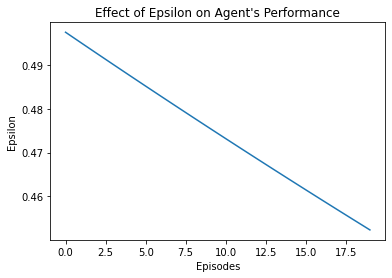

In [36]:
import matplotlib.pyplot as plt
# Plot the effect of epsilon
plt.plot(epsilons)
plt.xlabel("Episodes")
plt.ylabel("Epsilon")
plt.title("Effect of Epsilon on Agent's Performance")
plt.show()